In [12]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [13]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [14]:
X = sigmax()
Z = sigmaz()
Y = sigmay()
I = qeye(2)

S_X = tensor(X, X, X, X)
S_Z = tensor(Z, Z, Z, Z)

X_L_1 = tensor(X, I, X, I)
Z_L_1 = tensor(Z, Z, I, I)

X_L_2 = tensor(I, X, I, X)
Z_L_2 = tensor(I, I, Z, Z)

G = [tensor(X,X,I,I), 
     tensor(Z,I,Z,I),
     tensor(I,I,X,X),
     tensor(I,Z,I,Z)]
     

# Logical states
logical_zero = (tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0))+
                tensor(basis(2, 1), basis(2, 1), basis(2, 1), basis(2, 1))).unit()
ancilla_zero = (tensor(basis(2, 0), basis(2, 0), basis(2, 1), basis(2, 1))+
                tensor(basis(2, 1), basis(2, 1), basis(2, 0), basis(2, 0))).unit()

logical_one = X_L_1 * logical_zero
ancilla_one = X_L_2 * ancilla_zero

print("logical_zero")
print_quantum_state_as_superposition(logical_zero)
print("ancilla_zero")
print_quantum_state_as_superposition(ancilla_zero)
print("logical_one")
print_quantum_state_as_superposition(logical_one)
print("ancilla_one")
print_quantum_state_as_superposition(ancilla_one)


# initial_state = logical_one + logical_zero
print("initial state is ")
initial_state = logical_zero
print_quantum_state_as_superposition(initial_state)

logical_zero
|ψ⟩ = 0.71|0000⟩ + 0.71|1111⟩
ancilla_zero
|ψ⟩ = 0.71|0011⟩ + 0.71|1100⟩
logical_one
|ψ⟩ = 0.71|0101⟩ + 0.71|1010⟩
ancilla_one
|ψ⟩ = 0.71|0110⟩ + 0.71|1001⟩
initial state is 
|ψ⟩ = 0.71|0000⟩ + 0.71|1111⟩


In [15]:
T_max = 10
times = np.linspace(0, T_max, 50)
sigma = 1
omega_max = 10
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
delta_t = lambda t: 2*omega_max*(t / (T_max/2) - 1)


In [16]:
def H(t):
    """
    Rapid Adiabatic Hamiltonian
    """
    return  X_L_1 * omega_t(t) + Z_L_1 * delta_t(t)

def H_error_gaussian(t, error_time, strength):
    """
    Error Hamiltonian localized at a specific time (e.g., bit-flip on the first qubit).
    """
    error_width = 0.5
    f_t = strength * np.exp(-((t - error_time) ** 2) / (2 * error_width ** 2))
    return f_t * tensor(X, I, I, I)

def H_error(t, error_time, strength, duration=2):
    if error_time <= t < error_time + duration:
        # ramp_strength = strength * (t - error_time) / duration
        bit_flip_1 = tensor(X, I, I, I)
        bit_flip_2 = tensor(I, X, I, I)
        bit_flip_3 = tensor(I, I, X, I) 
        bit_flip_4 = tensor(I, I, I, X)
        return strength * bit_flip_1
    else:
        # Identity when error is not active
        return tensor(I, I, I, I)

def H_supp(x, z, nu1, nu2, lambda1, lambda2, opt):
    X_A = tensor(X, X, I, I)
    Z_A = tensor(Z, I, Z, I)
    H_supp_stab = S_X + S_Z
    H_supp_gauge = -(lambda1 + lambda2*x) * X_A -(nu1 + nu2*z) * Z_A
#     H_supp_gauge = -sum(G)
    if opt == 'stab':
        return H_supp_stab
    elif opt == 'gauge':
        return H_supp_gauge
    else:
        raise ValueError
    
def H_total(t, error_time, error_strength, duration, x, z, nu1, nu2, lambda1, lambda2, opt, Ep):
    """
    Total Hamiltonian including AQC evolution and error simulation.
    """
    H_n = H(t) + Ep * H_supp(x, z, nu1, nu2, lambda1, lambda2, opt) + H_error(t, error_time, error_strength, duration)
    return H_n


In [17]:
lambda1 = 1
lambda2 = 1
nu1 = 1
nu2 = 1
x = -1
z = 1
Ep = -200
error_time = 6
duration = T_max - error_time
error_strength = 50
opt = 'gauge'

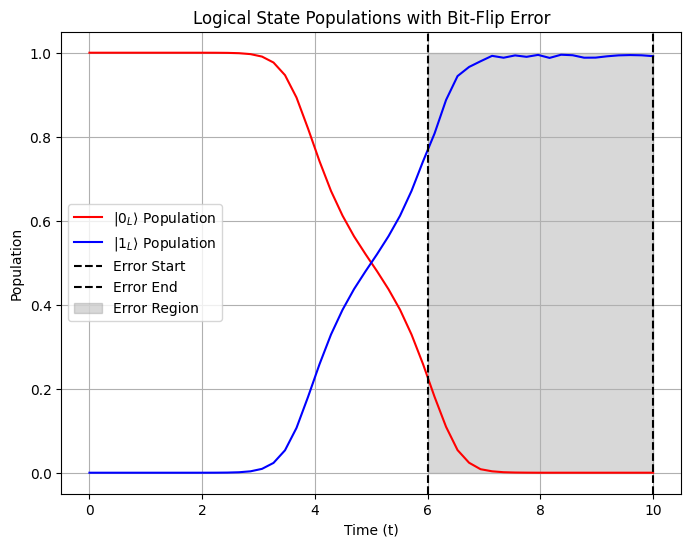

In [18]:
# Simulate evolution
e_ops = [logical_zero*logical_zero.dag(), logical_one*logical_one.dag()]

result = sesolve(lambda t: H_total(t, error_time, error_strength, duration, x, z, nu1, nu2, lambda1, lambda2, opt, Ep),
                 logical_zero, times, e_ops=e_ops, 
                 options={'nsteps': 1e5})

plt.figure(figsize=(8, 6))
plt.plot(times, result.expect[0], label=r"$|0_L\rangle$ Population", color='red')
plt.plot(times, result.expect[1], label=r"$|1_L\rangle$ Population", color='blue')
# Add vertical lines for the start and end of the error
plt.axvline(error_time, color='black', linestyle='--', label="Error Start")
plt.axvline(error_time + duration, color='black', linestyle='--', label="Error End")

# Shade the area between the lines
plt.fill_betweenx(
    [0, 1],  # Adjust y-limits based on your data range
    error_time,
    error_time + duration,
    color='gray',
    alpha=0.3,
    label="Error Region"
)

plt.xlabel("Time (t)")
plt.ylabel("Population")
plt.title("Logical State Populations with Bit-Flip Error")
plt.legend()
plt.grid()
plt.show()

In [19]:
def bose_einstein_distribution(energy_diff, temperature):
    if temperature == 0:
        return 0
    return 1 / (np.exp(energy_diff / (temperature)) - 1)

def gab(omega1, omega2, lambda_2):
    if omega1 >= omega2:
        return 0
    return np.sqrt(lambda_2)

def c_ops_gen_new(t, args):
    H_inst_t = args['args_H'](t)  # Instantaneous Hamiltonian at time t
    eigenvalues, eigenstates = H_inst_t.eigenstates()

    c_ops = []
    for a_i, a in enumerate(eigenstates):

        omega_a = eigenvalues[a_i]
        for b_i, b in enumerate(eigenstates[a_i+1:]):
            omega_b = eigenvalues[a_i + b_i + 1]
            
            c = b*a.dag()
            c_coef = 0
            for i in range(args['n_qubits']):
                sigmam_i = tensor([sigmam() if j == i else I for j in range(args['n_qubits'])])
                
                if np.abs(omega_a - omega_b) < 1e-6:
                    continue  # Skip nearly degenerate states
                
                # For decay transitions (omega_b > omega_a)
                if omega_b > omega_a:
                    Nba = bose_einstein_distribution(omega_b - omega_a, args['T'])
                    g_ba = gab(omega_a, omega_b, args['lambda_2'])

                    ma_ba = a.dag() * sigmam_i * b * b.dag() * sigmam_i.dag() * a
#                     ma_ba = np.abs(ma_ba)
#                     if ma_ba > 1e-6:
                    decay_op = np.sqrt(Nba * (g_ba ** 2) * ma_ba)
                    c_coef += decay_op

                # For excitation transitions (omega_a > omega_b)
                elif omega_a > omega_b:
                    Nab = bose_einstein_distribution(omega_a - omega_b, args['T'])
                    g_ab = gab(omega_b, omega_a, args['lambda_2'])
                    ma_ab = b.dag() * sigmam_i * a * a.dag() * sigmam_i.dag() * b
                    excitation_op = np.sqrt((Nab + 1) * (g_ab ** 2) * ma_ab)                    
                    c_coef += excitation_op
                    
                    
            if c_coef > 1e-5:
                c_ops.append(c.to('csr')*c_coef)

    return c_ops

In [20]:
# g1 = tensor(Z, Z, I)
# g2 = tensor(I, Z, Z)
# G = [g1, g2]
# X_L = tensor(X, X, X)
# Z_L = (tensor(Z, I, I) + tensor(I, Z, I) + tensor(I, I, Z)) / 3
# logical_zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
# logical_one = X_L * logical_zero
# initial_state = logical_zero
# n_qubits = 3

|ψ⟩ = 0.71|0000⟩ + 0.71|1111⟩
0
50
100
200
300


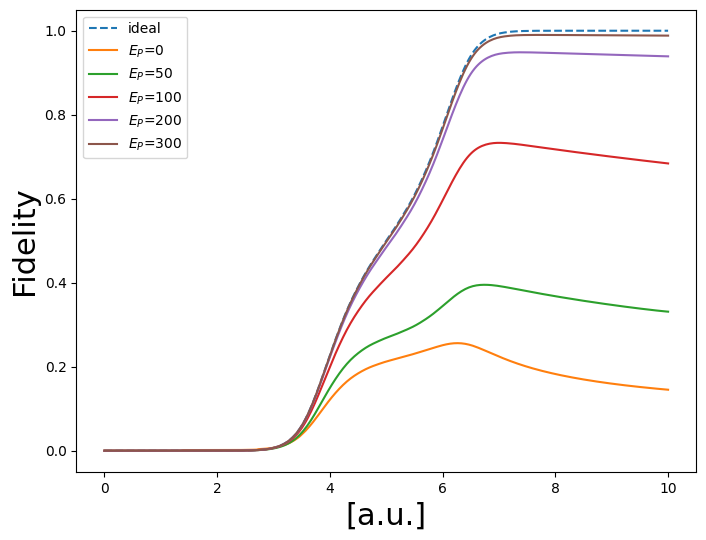

Done


In [22]:
print_quantum_state_as_superposition(initial_state)

n_qubits = 4
sigma = 1
omega_max = 10
max_time = 10
times = np.linspace(0, max_time,301) # has to be +1 for the final time stamp

nsteps = 1e5
gamma_sqrt = 0.1
T = 50 # temp
# T = 40 # temp

# Time-dependent functions
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - max_time/2) / sigma) ** 2)    
delta_t = lambda t: 2 * omega_max * (t / (max_time / 2) - 1)


Eps = [0, 50, 100, 200, 300]
# Eps = [0, 5, 10, 25, 50, 100]

rho0 = logical_zero * logical_zero.dag()
rho1 = logical_one * logical_one.dag()
rho_A_0 = ancilla_zero * ancilla_zero.dag()
rho_A_1 = ancilla_one * ancilla_one.dag()
e_ops = [rho0, rho1]

plt.figure(figsize=(8, 6))

# Plotting Ideal
def H_se(t):
    return omega_t(t) * X_L_1 + delta_t(t) * Z_L_1
    # return omega_t(t) * X_L + delta_t(t) * Z_L

results_se = sesolve(H_se, logical_zero, times, e_ops=e_ops)
# plt.plot(times, results_se.expect[0], linestyle="--", label=r"$\rho_0$ - ideal")
plt.plot(times, results_se.expect[1], linestyle="--", label=r"ideal")

# Loop over different values of Ep
for Ep in Eps:

    print(Ep)
    
    rho_init = initial_state * initial_state.dag()
    e_ops = [rho0, rho1, rho_A_0, rho_A_1]
    # e_ops = [rho0, rho1]
    
    # Time-dependent Hamiltonian
    def H_t(t):
        H_RAP = X_L_1 * omega_t(t) + Z_L_1 * delta_t(t)
        # H_RAP = X_L * omega_t(t) + Z_L * delta_t(t)
        
        # Ht = H_RAP + Ep * H_supp(x, z, nu1, nu2, lambda1, lambda2, opt)
        Ht = H_RAP - Ep * sum(G)
#       Z_A = tensor(Z, I, Z, I)
#       Ht = H_RAP - Ep * (Z_A)
        return Ht.to('csr')  # Assuming H_x and H_z are valid Qobjs

    args_C = {"args_H": H_t,
              "n_qubits": n_qubits,
              "lambda_2":gamma_sqrt,
              "T":T}

    prev_time = times[0]
    expects_0 = []
    expects_1 = []
    expects_0_A = []
    expects_1_A = []
    
    time_inter = times[1] - times[0]

    tot_time = times[1:]
    tot_time = np.append(tot_time, times[-1] + time_inter)


    
    for dt in tot_time:
        c_ops = c_ops_gen_new(dt, args=args_C)
        t_steps = [prev_time, dt]
        results = mesolve(H_t, rho_init, t_steps, c_ops=c_ops, args=args_C, e_ops=e_ops, 
                          options={'store_states': True})

        # Updating
        prev_time = dt
        rho_init = results.states[-1]

        # Saving
        expects_1.append(results.expect[1][0])
        expects_0.append(results.expect[0][0])
        expects_0_A.append(results.expect[2][0])
        expects_1_A.append(results.expect[3][0])
    
    # Plotting results
    expects_all = [expects_1[i] + expects_1_A[i] for i in range(len(expects_1))]
    # expects_all = [expects_1[i] for i in range(len(expects_1))]
    # expects_all = [expects_1[i] for i in range(len(expects_1))]
    # expects_all = [expects_1[i] / (expects_1[i] + expects_0[i]) for i in range(len(expects_1))]
    # plt.plot(times, expects_0, label=r"$0_L - E_{P}$=" + str(Ep))
    # plt.plot(times, expects_1, label=r"$1_L - E_{P}$=" + str(Ep))
    # plt.plot(times, expects_0_A, label=r"$0_A - E_{P}$=" + str(Ep))
    # plt.plot(times, expects_1_A, label=r"$1_A - E_{P}$=" + str(Ep))
    
    plt.plot(times, expects_all, label=r"$E_{P}$=" + str(Ep))

    
    
plt.legend()
plt.xlabel('[a.u.]', size=22)
plt.ylabel('Fidelity', size=22)
plt.show()

# plt.savefig(f"plot_subsystems.pdf", format="pdf", dpi=300)
# plt.close()
# plt.savefig("3qubit_supp.svg", format="svg", dpi=300)
# plt.savefig("3qubit_supp.pdf", format="pdf", dpi=300)
# plt.savefig("3qubit_supp.pdf")
# plt.close()

print("Done")